# Clustering


In [1]:
!pip install scanpy
!pip install anndata

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 21.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 3.5 MB/s eta 0:00:00
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.12.2
    Uninstalling seaborn-0.12.2:
      Successfully uninstalled seaborn-0.12.2


In [2]:
import umap
import pickle
import numpy as np
from scipy.sparse import issparse
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from sklearn.cluster import KMeans
import pandas as pd
from sklearn.decomposition import PCA
import seaborn as sns
import pandas as pd


In [3]:

with open("/kaggle/input/embeddings-all/embedded_data_split_severity_celltype_progression_all.pkl", "rb") as f:  # Replace with your actual file path
    data = pickle.load(f)


X = data.get("embeddings")  
y = data.get("severity") 
c = data.get("celltype")
t = data.get("Sample time")

if issparse(X):
    X = X.toarray()



In [4]:
print(data.columns)
print(data["Sample time"])

Index(['embeddings', 'severity', 'celltype', 'Sample time'], dtype='object')
0          convalescence
1          convalescence
2          convalescence
3          convalescence
4          convalescence
               ...      
1462697    convalescence
1462698    convalescence
1462699    convalescence
1462700    convalescence
1462701    convalescence
Name: Sample time, Length: 1462702, dtype: object


In [5]:


X_numpy = np.array(X.tolist(), dtype=np.float32)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numpy)


## Finding K for Clustering

Calculating WCSS: 100%|██████████| 9/9 [39:30<00:00, 263.37s/it]


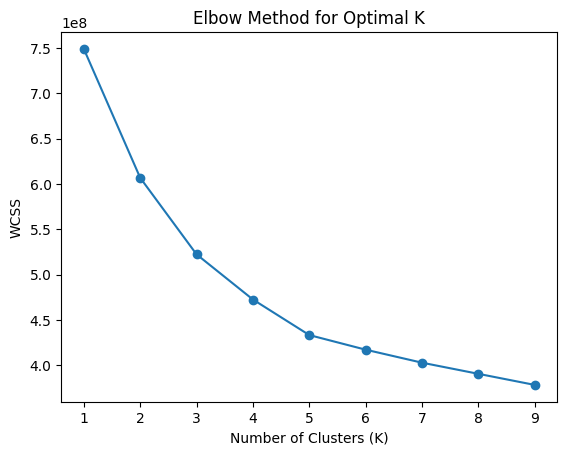

In [6]:

wcss = []
for i in tqdm(range(1, 10), desc="Calculating WCSS"):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)


plt.plot(range(1, 10), wcss, marker='o')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("WCSS")
plt.title("Elbow Method for Optimal K")
plt.show()


In [7]:


first_derivative = np.diff(wcss)


second_derivative = np.diff(first_derivative)


optimal_k = np.argmax(second_derivative) + 2  

print(f"Optimal K (Curvature Method): {optimal_k}")

Optimal K (Curvature Method): 2


**END OF FINDING OPTIMAL K (not needed if already found)**

In [8]:


#k = optimal_k 
k = 2
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
#adata.obs['cluster_kmeans'] = kmeans.fit_predict(X_scaled)  # Store cluster labels in adata


cluster_labels = kmeans.fit_predict(X_scaled)  # Get cluster assignments

# Store results in a DataFrame
df = pd.DataFrame(X_scaled, columns=[f'feature_{i}' for i in range(X_scaled.shape[1])])
df['cluster_kmeans'] = cluster_labels  # Add cluster labels
df['celltype'] =  c
df ['sampleTime'] = t

In [9]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

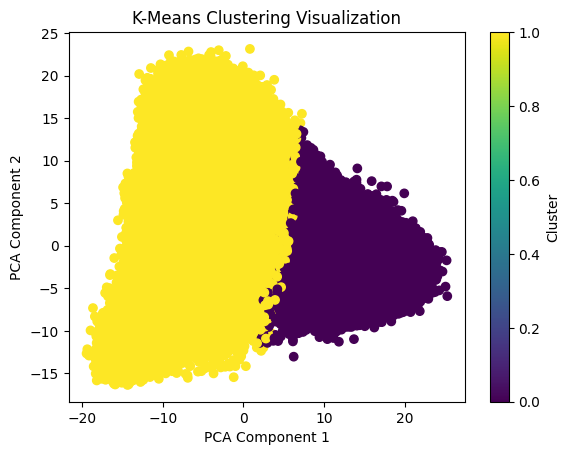

In [10]:

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['cluster_kmeans'], cmap='viridis')
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("K-Means Clustering Visualization")
plt.colorbar(label="Cluster")
plt.show()


In [11]:
#import umap

#umap_embedding = umap.UMAP(n_components=2, random_state=42).fit_transform(X_scaled)
#df['cluster_kmeans']
#plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=df['cluster_kmeans'], cmap='coolwarm')
#plt.xlabel("UMAP 1")
#plt.ylabel("UMAP 2")
#plt.title("UMAP Clustering Visualization")
#plt.colorbar(label="Cluster")
#plt.show()


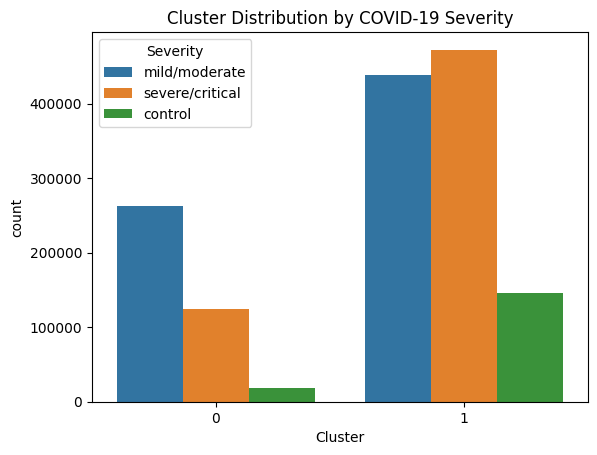

In [12]:


df_new = pd.DataFrame({"Severity": y, "Cluster": df['cluster_kmeans'], "TimeProgress": df['sampleTime'], "Celltype":df['celltype']})
sns.countplot(x="Cluster", hue="Severity", data=df_new)
plt.title("Cluster Distribution by COVID-19 Severity")
plt.show()


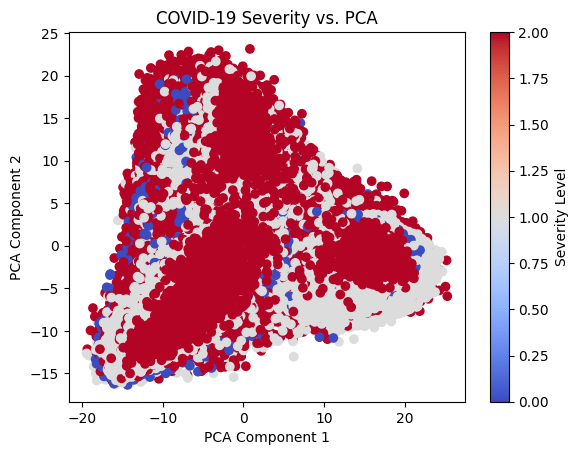

In [13]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df_new['Severity'].astype('category').cat.codes, cmap='coolwarm')
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("COVID-19 Severity vs. PCA")
plt.colorbar(label="Severity Level")
plt.show()

Following code is to see how good the assignments to the clusters are

In [14]:
true_labels = df_new['Severity'].astype('category').cat.codes
cluster_labels = df_new['Cluster']

df1 = pd.DataFrame({"True_Severity": true_labels, "Cluster": cluster_labels})

# Find majority class per cluster
majority_labels = df1.groupby("Cluster")["True_Severity"].agg(lambda x: x.value_counts().idxmax())

# Assign majority label as "predicted" for each cluster
predicted_labels = cluster_labels.map(majority_labels)

# Compute classification accuracy
accuracy = np.mean(predicted_labels == true_labels)
print(f"K-Means Baseline Accuracy: {accuracy:.4f}")

K-Means Baseline Accuracy: 0.5025


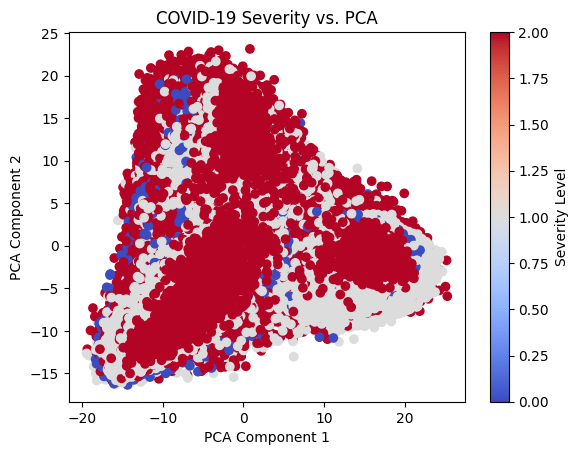

In [15]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df_new['Severity'].astype('category').cat.codes, cmap='coolwarm')
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("COVID-19 Severity vs. PCA")
plt.colorbar(label="Severity Level")
plt.show()

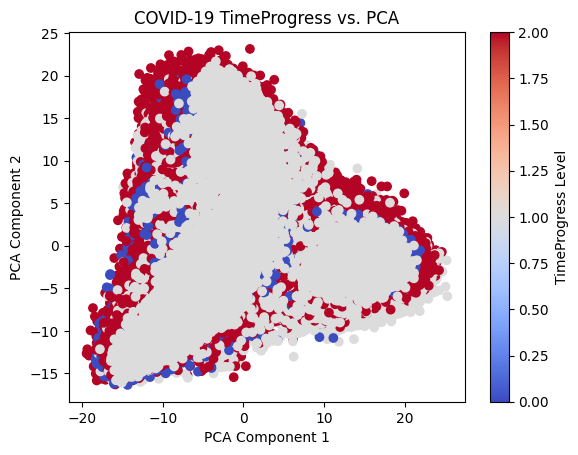

In [16]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df_new['TimeProgress'].astype('category').cat.codes, cmap='coolwarm')
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("COVID-19 TimeProgress vs. PCA")
plt.colorbar(label="TimeProgress Level")
plt.show()

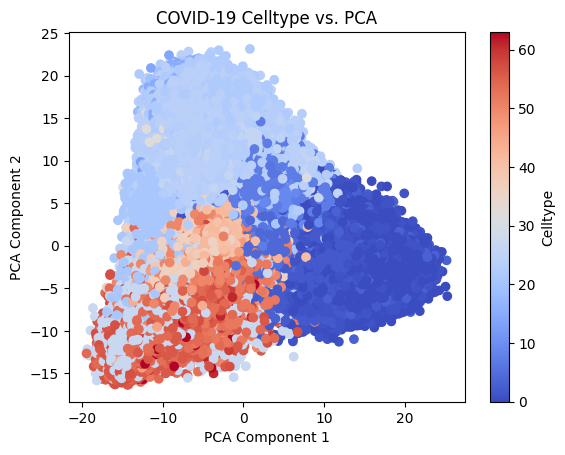

In [17]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df_new['Celltype'].astype('category').cat.codes, cmap='coolwarm')
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("COVID-19 Celltype vs. PCA")
plt.colorbar(label="Celltype")
plt.show()

In [18]:
from sklearn.metrics import adjusted_rand_score

# Calculate Adjusted Rand Index (ARI)
if y is not None:
    ari_score = adjusted_rand_score(y, df['cluster_kmeans'])
    print(f"Adjusted Rand Index (ARI): {ari_score:.4f}")
else:
    print("Severity labels (y) not found. ARI cannot be computed.")

Adjusted Rand Index (ARI): -0.0046


In [19]:
from sklearn.metrics import adjusted_rand_score

# Calculate Adjusted Rand Index (ARI)
if y is not None:
    ari_score = adjusted_rand_score(c, df['cluster_kmeans'])
    print(f"Adjusted Rand Index (ARI): {ari_score:.4f}")
else:
    print("Severity labels (y) not found. ARI cannot be computed.")

Adjusted Rand Index (ARI): 0.0815


In [20]:
from sklearn.metrics import adjusted_rand_score

# Calculate Adjusted Rand Index (ARI)
if y is not None:
    ari_score = adjusted_rand_score(t, df['cluster_kmeans'])
    print(f"Adjusted Rand Index (ARI): {ari_score:.4f}")
else:
    print("Severity labels (y) not found. ARI cannot be computed.")

Adjusted Rand Index (ARI): -0.0222


ARI is low. Not good seperation

In [21]:
from sklearn.metrics import silhouette_score
import numpy as np

#Calculate Silhoutte Score on a limited set of data due to computational reasons
sample_size = min(50000, len(X_scaled))  # Limit to 15,000 points
indices = np.random.choice(len(X_scaled), sample_size, replace=False)

sil_score = silhouette_score(X_scaled[indices], cluster_labels[indices])
print(f"Silhouette Score (sampled): {sil_score:.4f}")


Silhouette Score (sampled): 0.2029
